## Movie Recommendation System

In [1]:
# Importing the libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.spatial import distance 

### 1. Load Dataset

In [2]:
# Read movies dataset
df_movies = pd.read_csv('data/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Read ratings dataset
df_ratings = pd.read_csv('data/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
# Read tags dataset
df_tags = pd.read_csv('data/tags.csv')
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [5]:
# Combine df_movies and df_ratings
df_movies_ratings = pd.merge(df_movies, df_ratings, on='movieId', how='inner')
df_movies_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [6]:
# Combine df_movies_ratings and df_tags
df_final = pd.merge(df_movies_ratings, df_tags, on=['userId', 'movieId'], how='inner')
df_final.head()

,movieId,title,genres,userId,rating,timestamp_x,tag,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,4.0,1122227329,pixar,1139045764
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474,4.0,978575760,pixar,1137206825
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567,3.5,1525286001,fun,1525286013
3,2,Jumanji (1995),Adventure|Children|Fantasy,62,4.0,1528843890,fantasy,1528843929
4,2,Jumanji (1995),Adventure|Children|Fantasy,62,4.0,1528843890,magic board game,1528843932


### 2. Exploratory Data Analysis

In [7]:
df_final.shape

(3476, 8)

In [8]:
df_final.describe()

,movieId,userId,rating,timestamp_x,timestamp_y
count,3476.000000,3476.000000,3476.000000,3.476000e+03,3.476000e+03
mean,28009.502301,429.785386,4.016830,1.297281e+09,1.323525e+09
std,44138.125029,161.552990,0.856925,2.038080e+08,1.731554e+08
min,1.000000,2.000000,0.500000,9.746667e+08,1.137179e+09
25%,1261.500000,424.000000,3.500000,1.100120e+09,1.138032e+09
50%,4492.000000,474.000000,4.000000,1.281766e+09,1.279956e+09
75%,45499.000000,523.250000,5.000000,1.498457e+09,1.498457e+09
max,193565.000000,610.000000,5.000000,1.537099e+09,1.537099e+09


The dataset has 3476 rows and 8 columns, with each row representing the information of a movie with user ratings. It includes identification information such as movieId ,title, genres, ratings and userId.

In [10]:
print("Number of unique users: ", df_ratings["userId"].nunique())
print("Number of unique movies: ", df_ratings["movieId"].nunique())

Number of unique users:  610
Number of unique movies:  9724


In [11]:
print('Frequency of each rating value:')
print(df_ratings['rating'].value_counts())

Frequency of each rating value:
rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64


##### 2.1 Duplicate rows

In [13]:
print(df_final.duplicated().sum())

0


There are 0 rows of duplicate data in the dataset

##### 2.2 Missing values

In [14]:
# Check for missing values and print columns and sum of missing values

print(df_final.isnull().sum())

print("Num of rows with missing values: ", (df_final.isnull().any(axis=1)).sum())

movieId        0
title          0
genres         0
userId         0
rating         0
timestamp_x    0
tag            0
timestamp_y    0
dtype: int64
Num of rows with missing values:  0


There are no missing values in the dataset.

##### 2.3 Distribution of numerical columns

In [15]:
numerical_cols = df_final[df_final.columns[(df_final.dtypes == 'float64') | (df_final.dtypes == 'int64')]]
numerical_cols.shape

(3476, 5)

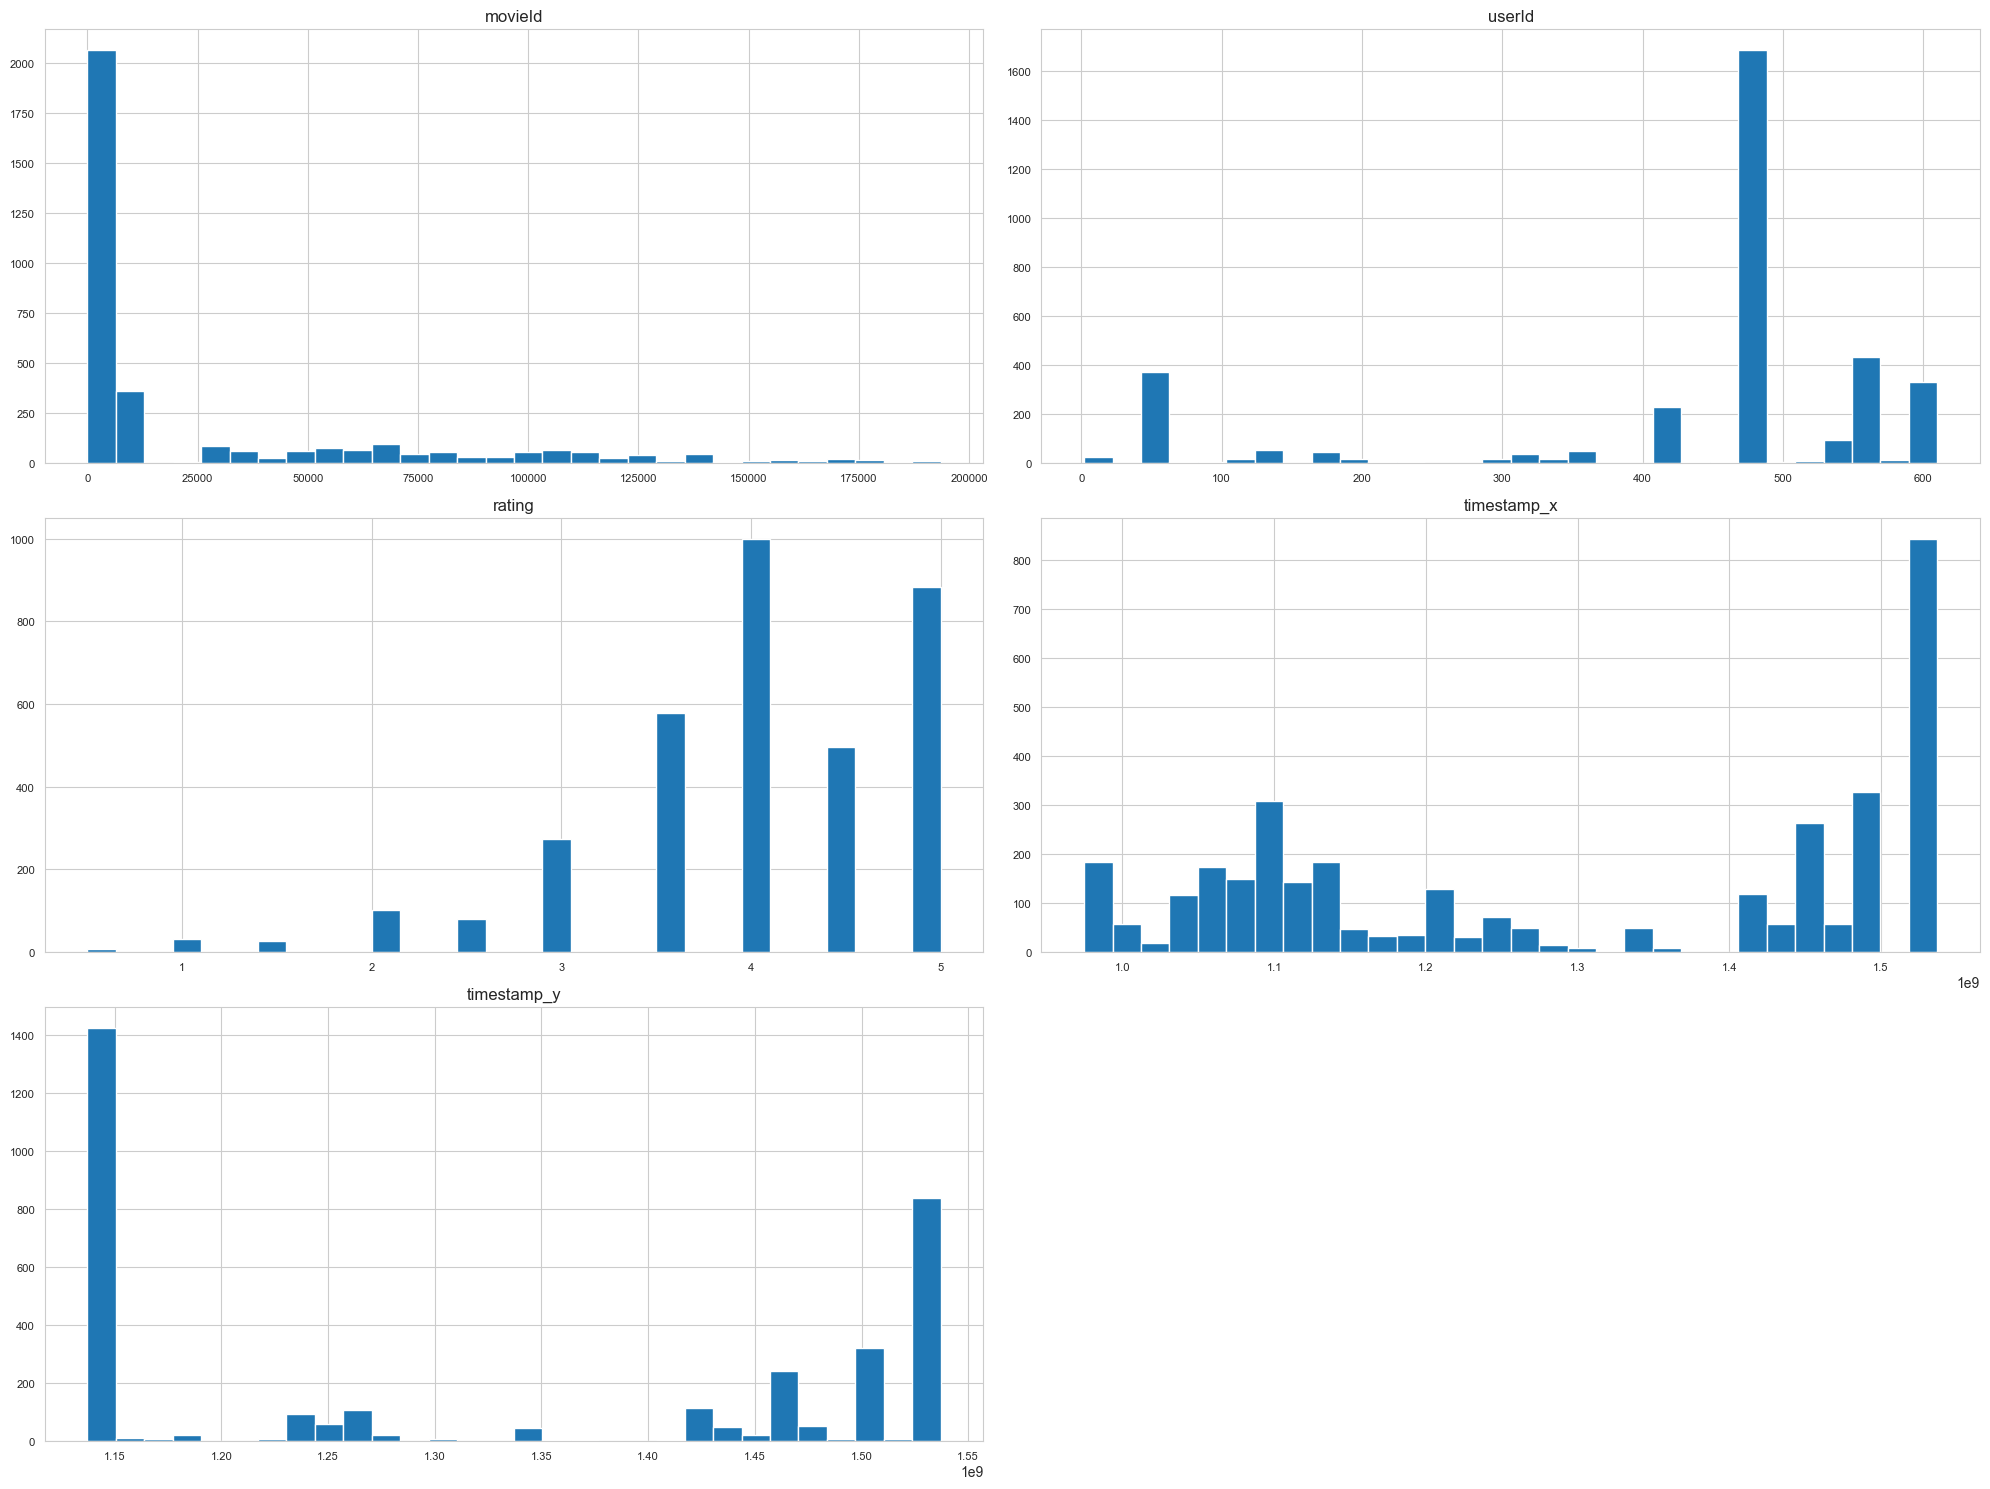

In [16]:
# Distribution of numerical columns as a grid

sns.set_style('whitegrid')
numerical_cols.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [15]:
import datetime

df_ratings['timestamp'] = df_ratings['timestamp'].apply(datetime.datetime.fromtimestamp)
df_ratings['year'] = df_ratings['timestamp'].dt.year
df_ratings['month'] = df_ratings['timestamp'].dt.month
df_ratings['date'] = df_ratings['timestamp'].dt.date

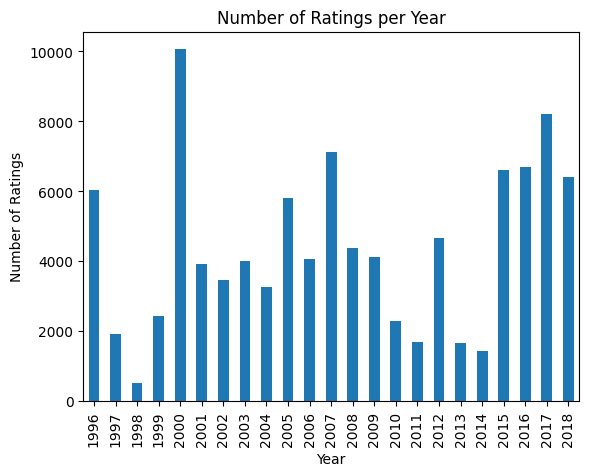

In [18]:
# Group ratings by year and count the number of ratings for each year
df_yearly_counts = df_ratings.groupby('year')['rating'].count().sort_index()
df_yearly_counts.plot.bar()

plt.xlabel('Year')
plt.ylabel('Number of Ratings')

# Add a title to the plot
plt.title('Number of Ratings per Year')

# Display the plot
plt.show()

An interesting point deduced from the ratings is that most of the movies have rating between 3.5 to 5

##### 2.4 Categorical Columns

In [17]:
categorical_cols = df_final[df_final.columns[(df_final.dtypes == 'object') | (df_final.dtypes == 'bool')]]
df_final.describe(include=['object', 'bool'])

,title,genres,tag
count,3476,3476,3476
unique,1464,364,1543
top,Pulp Fiction (1994),Drama,In Netflix queue
freq,181,328,55


##### 2.5 Correlation Heatmap

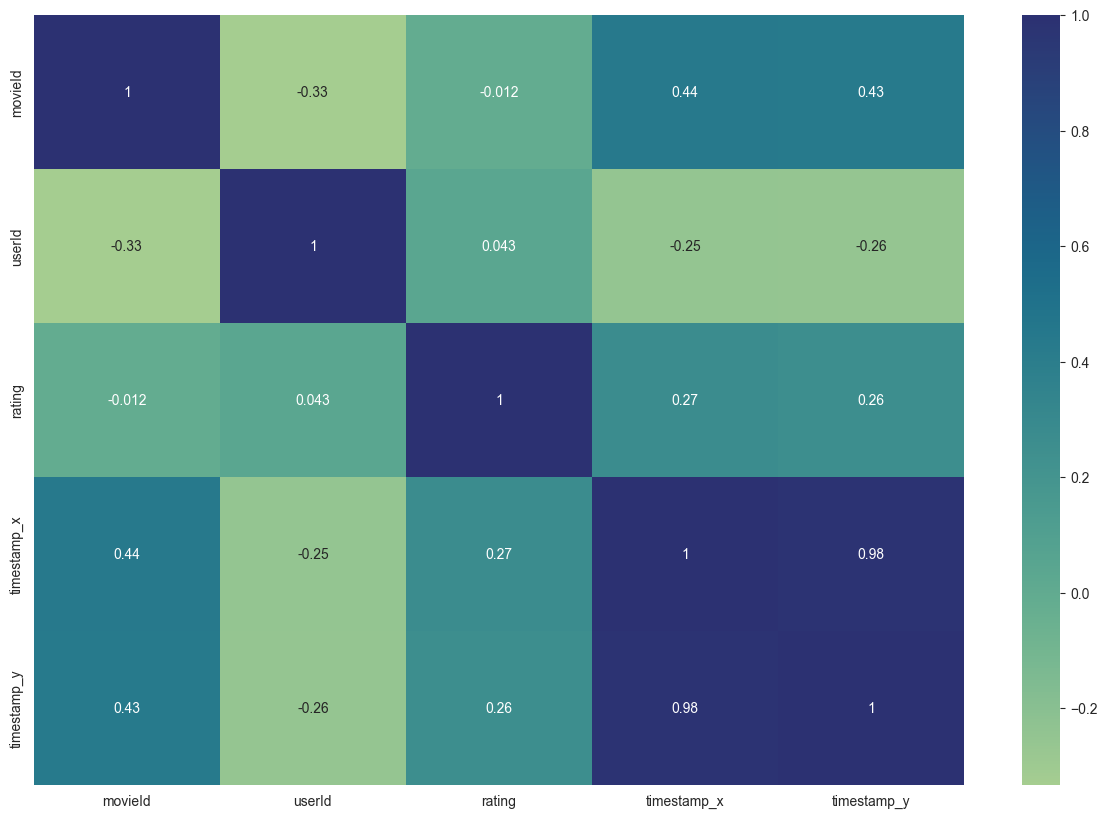

In [18]:
# heatmap of correlation between numerical columns

corr = numerical_cols.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='crest')
plt.show()

#### 2.5 Analyzing Movie Data

In [20]:
df_movies['genres'].value_counts()

genres
Drama                                                  1053
Comedy                                                  946
Comedy|Drama                                            435
Comedy|Romance                                          363
Drama|Romance                                           349
                                                       ... 
Action|Crime|Horror|Mystery|Thriller                      1
Adventure|Animation|Children|Comedy|Musical|Romance       1
Action|Adventure|Animation|Comedy|Crime|Mystery           1
Children|Comedy|Fantasy|Sci-Fi                            1
Action|Animation|Comedy|Fantasy                           1
Name: count, Length: 951, dtype: int64

In [24]:
genre_lists = df_movies["genres"].str.split('|')
unique_genres = genre_lists.explode().unique()

unique_genres

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [26]:
df_movie = df_movies.join(df_movies['genres'].str.get_dummies().astype(bool))
df_movie.drop('genres', inplace=True, axis=1)

df_movie.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),False,False,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men (1995),False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale (1995),False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II (1995),False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [27]:
# get the count of each genre
genre_counts = df_movie.iloc[:, 3:].sum()

# print the genre counts
print(genre_counts)

Action         1828
Adventure      1263
Animation       611
Children        664
Comedy         3756
Crime          1199
Documentary     440
Drama          4361
Fantasy         779
Film-Noir        87
Horror          978
IMAX            158
Musical         334
Mystery         573
Romance        1596
Sci-Fi          980
Thriller       1894
War             382
Western         167
dtype: int64


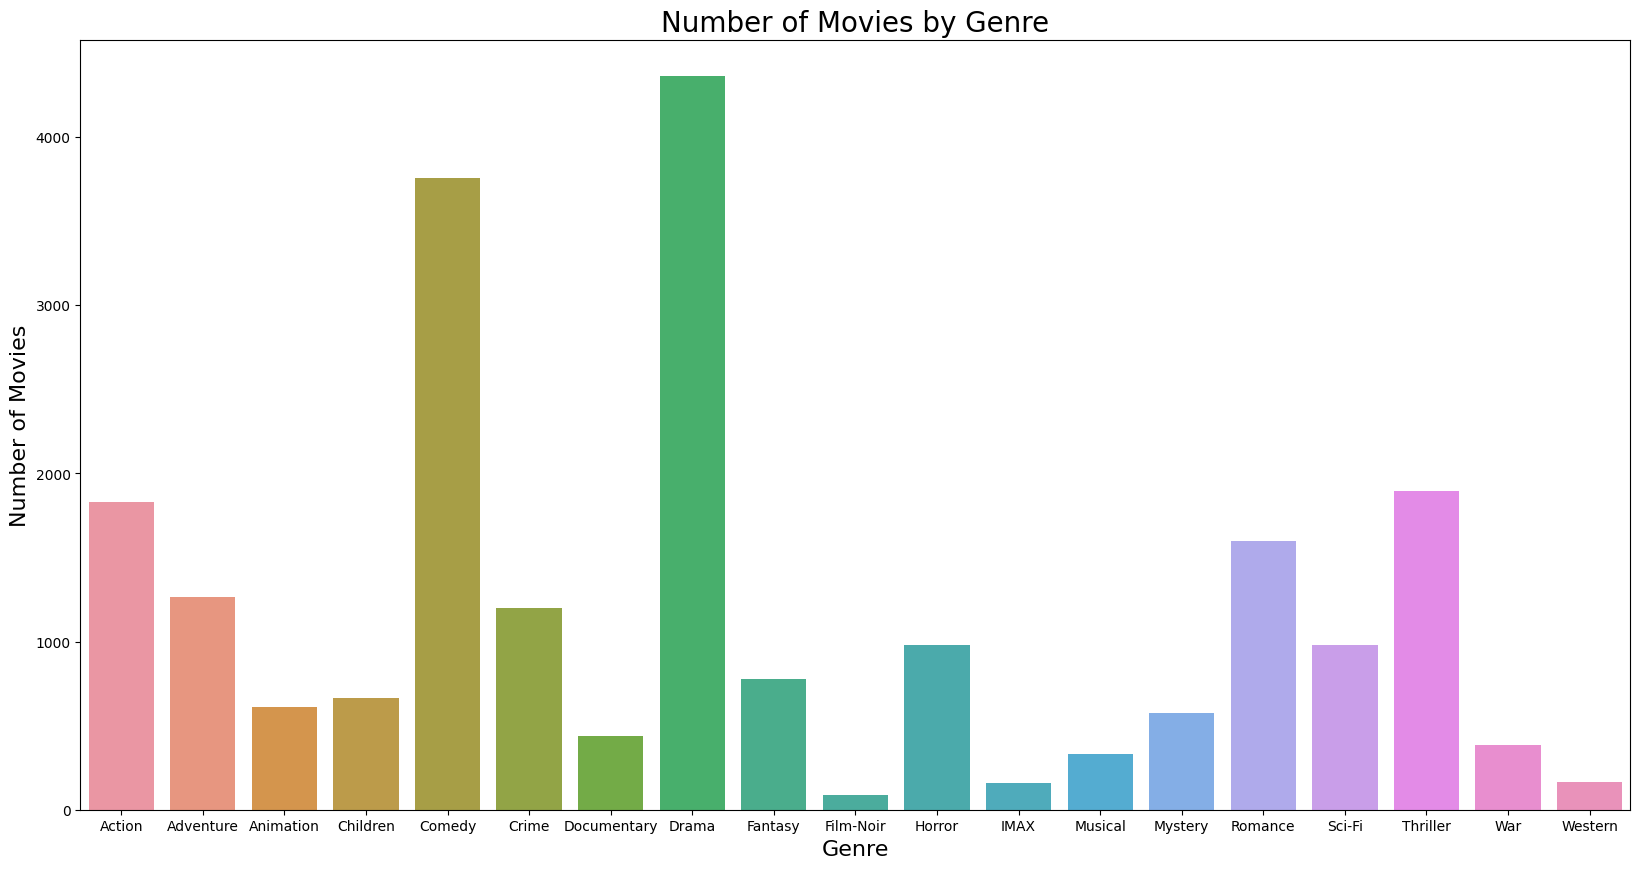

In [38]:
plt.figure(figsize=(20, 10))

# create a bar plot of the true counts for each genre
sns.barplot(x=genre_counts.index.values, y=genre_counts.values)

# set the x-axis label
plt.xlabel('Genre', fontsize=16)

# set the y-axis label
plt.ylabel('Number of Movies', fontsize=16)

# set the plot title
plt.title('Number of Movies by Genre', fontsize=20)

# display the plot
plt.show()

In [30]:
df_rating_movie_merged = pd.merge(df_ratings, df_movie, on='movieId')
df_rating_movie_merged.head()

,userId,movieId,rating,timestamp,year,month,date,title,(no genres listed),Action,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000-07-30 14:45:03,2000,7,2000-07-30,Toy Story (1995),False,False,...,False,False,False,False,False,False,False,False,False,False
1,5,1,4.0,1996-11-08 01:36:02,1996,11,1996-11-08,Toy Story (1995),False,False,...,False,False,False,False,False,False,False,False,False,False
2,7,1,4.5,2005-01-25 01:52:26,2005,1,2005-01-25,Toy Story (1995),False,False,...,False,False,False,False,False,False,False,False,False,False
3,15,1,2.5,2017-11-13 07:59:30,2017,11,2017-11-13,Toy Story (1995),False,False,...,False,False,False,False,False,False,False,False,False,False
4,17,1,4.5,2011-05-18 01:28:03,2011,5,2011-05-18,Toy Story (1995),False,False,...,False,False,False,False,False,False,False,False,False,False


In [33]:
genre_columns = ['Action', 'Adventure', 'Animation', "Children", 'Comedy', 
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
data = []
for genre in genre_columns:
    avg_rating = df_rating_movie_merged[df_rating_movie_merged[genre] == True]['rating'].mean()
    data.append({'genre': genre, 'average_rating': avg_rating})

df_genre_ratings = pd.DataFrame(data)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Action'),
  Text(1, 0, 'Adventure'),
  Text(2, 0, 'Animation'),
  Text(3, 0, 'Children'),
  Text(4, 0, 'Comedy'),
  Text(5, 0, 'Crime'),
  Text(6, 0, 'Documentary'),
  Text(7, 0, 'Drama'),
  Text(8, 0, 'Fantasy'),
  Text(9, 0, 'Film-Noir'),
  Text(10, 0, 'Horror'),
  Text(11, 0, 'Musical'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Romance'),
  Text(14, 0, 'Sci-Fi'),
  Text(15, 0, 'Thriller'),
  Text(16, 0, 'War'),
  Text(17, 0, 'Western')])

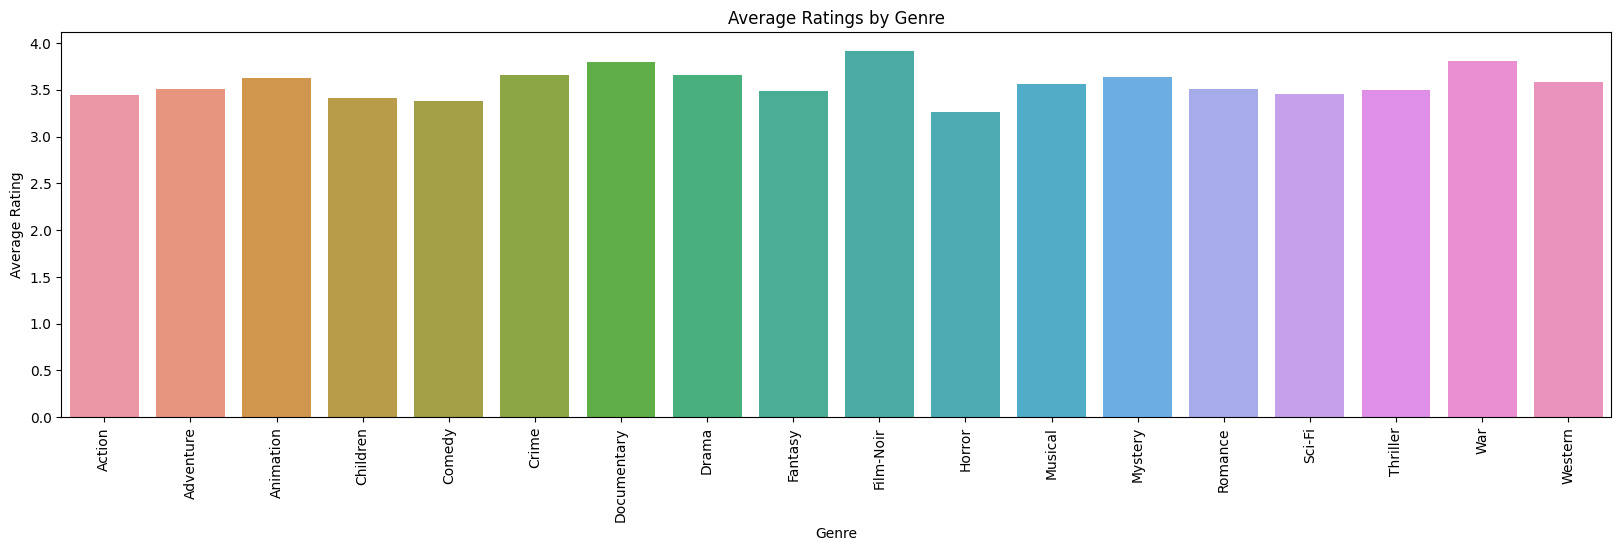

In [35]:
# Using seaborn plot the average rating for each genre
plt.figure(figsize=(20, 5))
sns.barplot(x='genre', y='average_rating', data=df_genre_ratings)

# Set the title and axis labels
plt.title('Average Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)
